In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import hilbert
from scipy.signal import butter, filtfilt
import noisereduce as nr
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import torch
from sklearn.neighbors import KNeighborsClassifier

In [2]:

# --- Path to dataset ------------------------------------------------------
data_path = Path('free-spoken-digit-dataset/recordings')   # adjust if you moved the folder
assert data_path.is_dir(), f"Dataset not found at {data_path.resolve()}"

# --- List only .wav files -------------------------------------------------
wav_files = sorted(p for p in data_path.glob('*.wav'))
print("First 5 files:", [p.name for p in wav_files[:5]])

# --- Load the first file --------------------------------------------------
audio, sr = librosa.load(wav_files[0], sr=None)    # sr=None keeps original 8 kHz
print(f"Sample rate: {sr} Hz   |   Audio shape: {audio.shape}")


First 5 files: ['0_george_0.wav', '0_george_1.wav', '0_george_10.wav', '0_george_11.wav', '0_george_12.wav']
Sample rate: 8000 Hz   |   Audio shape: (2384,)


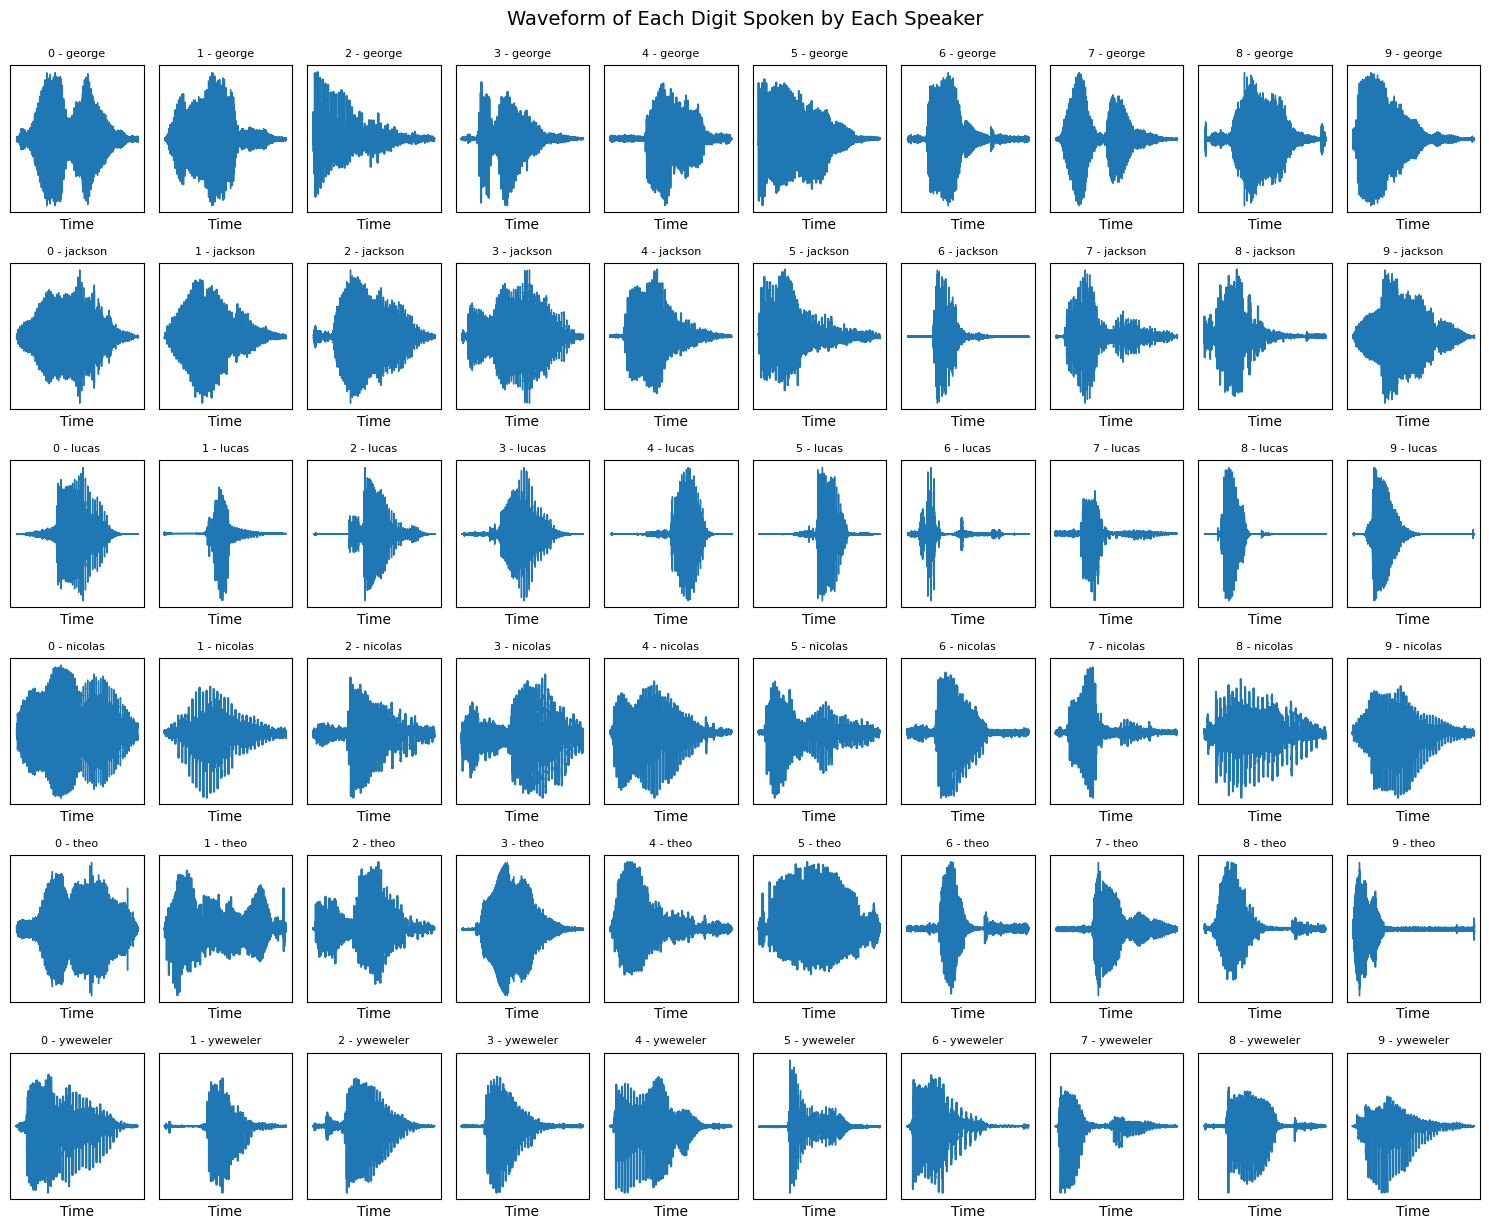

In [3]:

# Load all recordings
data_path = 'free-spoken-digit-dataset/recordings'
files = [f for f in os.listdir(data_path) if f.endswith('.wav')]

# Extract unique digits and speakers
digits = list(range(10))
speakers = sorted(set(f.split('_')[1] for f in files))

# Prepare figure grid
plt.figure(figsize=(15, len(speakers) * 2))

plot_num = 1

for speaker in speakers:
    for digit in digits:
        # Find one matching file
        match = [f for f in files if f.startswith(f"{digit}_{speaker}")]
        if not match:
            continue
        filepath = os.path.join(data_path, match[0])
        y, sr = librosa.load(filepath)

        # Plot waveform the snippet below into a new code cell and run it once; all your original plotting cells will then work unchanged.
        plt.subplot(len(speakers), len(digits), plot_num)
        librosa.display.waveshow(y, sr=sr)
        plt.xticks([]); plt.yticks([])
        plt.title(f'{digit} - {speaker}', fontsize=8)
        plot_num += 1

plt.tight_layout()
plt.suptitle('Waveform of Each Digit Spoken by Each Speaker', fontsize=14, y=1.02)
plt.show()


In [4]:
# ── New helper cell: build df from your existing variables ────────────────
import pandas as pd
import librosa
from pathlib import Path
import os

# Ensure 'data_path' and 'files' already exist (they do in your notebook)
assert 'data_path' in globals() and 'files' in globals(), "Run the dataset‑loading cell first."

metadata = []
for fname in files:                     # use the same 'files' list you built earlier
    try:
        digit, speaker, index = fname.split('_')
        index = index.split('.')[0]     # strip ".wav"
        filepath = Path(data_path) / fname
        duration = librosa.get_duration(path=str(filepath))
        metadata.append({
            'digit': int(digit),
            'speaker': speaker,
            'index': int(index),
            'duration': duration,
            'filepath': str(filepath)
        })
    except Exception as e:
        print(f"Skipping {fname}: {e}")

df = pd.DataFrame(metadata)
print(f"df built with {len(df)} rows and columns {list(df.columns)}")


df built with 3000 rows and columns ['digit', 'speaker', 'index', 'duration', 'filepath']


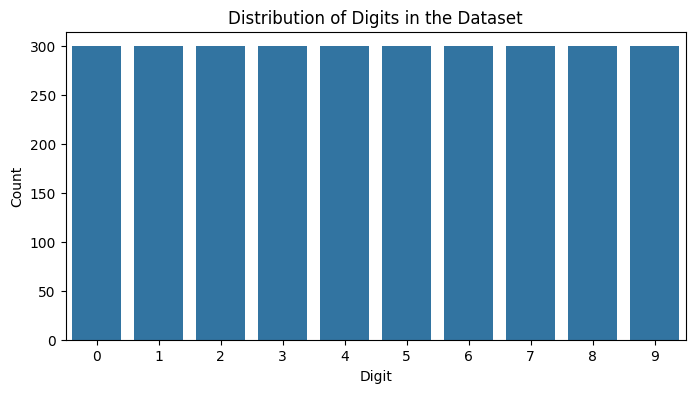

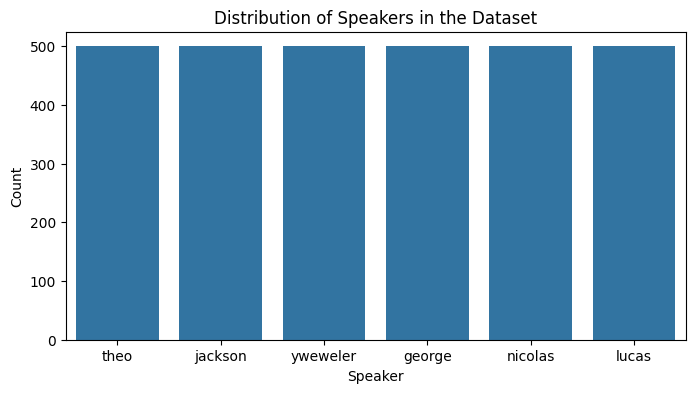

In [5]:

# Plot 1: Distribution of digits
plt.figure(figsize=(8, 4))
sns.countplot(x='digit', data=df)
plt.title('Distribution of Digits in the Dataset')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

# Plot 2: Distribution of speakers
plt.figure(figsize=(8, 4))
sns.countplot(x='speaker', data=df)
plt.title('Distribution of Speakers in the Dataset')
plt.xlabel('Speaker')
plt.ylabel('Count')
plt.show()

🔢 General Stats:
            digit     duration
count  3000.00000  3000.000000
mean      4.50000     0.437434
std       2.87276     0.147643
min       0.00000     0.143500
25%       2.00000     0.342344
50%       4.50000     0.419813
75%       7.00000     0.510281
max       9.00000     2.282750

📊 Duration by Digit:
           mean    median       min       max       std
digit                                                  
0      0.504021  0.491500  0.271750  1.167625  0.125389
1      0.405509  0.377750  0.174875  1.004500  0.132164
2      0.383915  0.356563  0.161000  1.213375  0.136892
3      0.400331  0.384062  0.181875  1.313000  0.151184
4      0.408263  0.398375  0.169875  1.114875  0.109347
5      0.453186  0.424375  0.209125  1.147250  0.119625
6      0.448528  0.441063  0.143500  0.977500  0.181154
7      0.461744  0.442125  0.245625  2.195875  0.174665
8      0.412862  0.399875  0.218625  1.142875  0.115464
9      0.495985  0.461750  0.222250  2.282750  0.159187


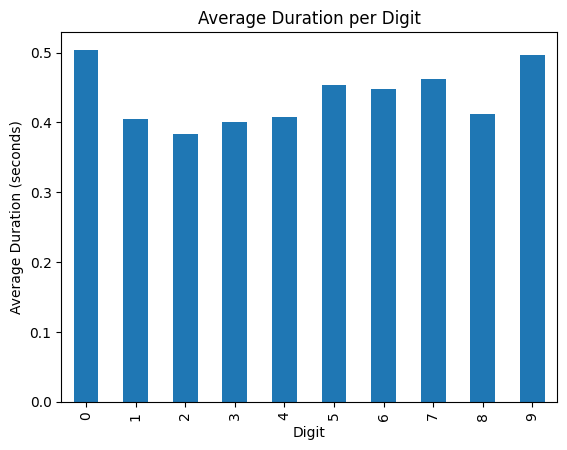


🧑 Duration by Speaker:
              mean    median       min       max       std
speaker                                                   
george    0.441717  0.430125  0.174875  0.999875  0.097588
jackson   0.516460  0.491687  0.344125  0.879750  0.107457
lucas     0.574211  0.541875  0.245625  1.313000  0.161731
nicolas   0.349188  0.348688  0.143625  0.574250  0.079630
theo      0.388862  0.369625  0.161000  2.282750  0.168451
yweweler  0.354168  0.347000  0.143500  0.683750  0.083247


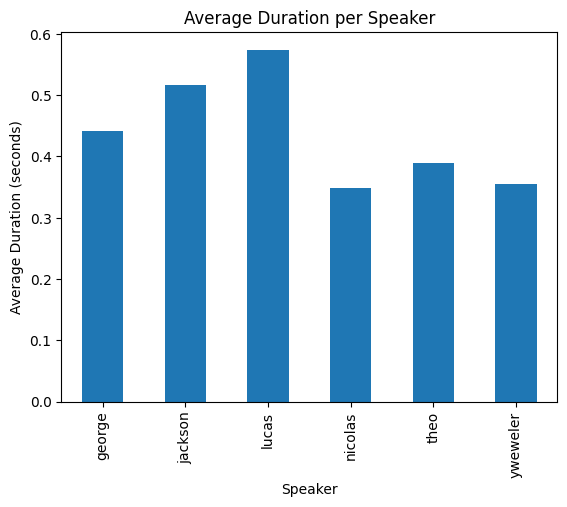

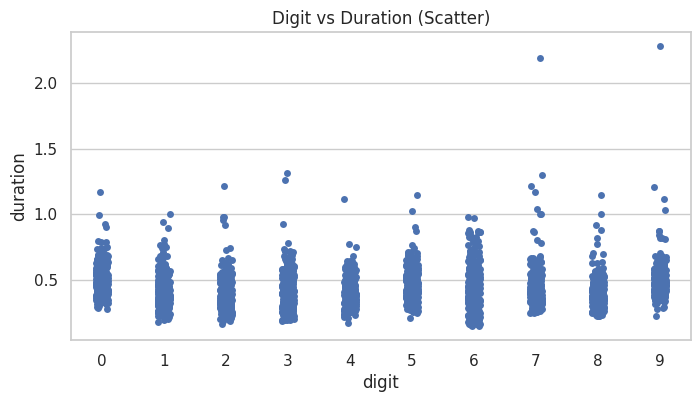

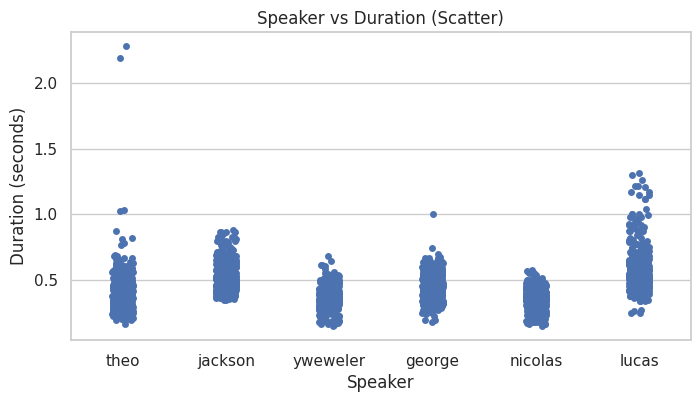

In [6]:
# Extract metadata
data_info = []
for f in files:
    digit, speaker, idx = f.replace('.wav', '').split('_')
    path = os.path.join(data_path, f)
    duration = librosa.get_duration(path=path)
    data_info.append([f, int(digit), speaker, int(idx), duration])

df = pd.DataFrame(data_info, columns=["filename", "digit", "speaker", "index", "duration"])

# Descriptive stats
print("🔢 General Stats:")
print(df[['digit', 'duration']].describe())

print("\n📊 Duration by Digit:")
print(df.groupby('digit')['duration'].agg(['mean', 'median', 'min', 'max', 'std']))

# Plot 1: Average Duration per Digit
df.groupby('digit')['duration'].mean().plot(kind='bar')
plt.title('Average Duration per Digit')
plt.xlabel('Digit')
plt.ylabel('Average Duration (seconds)')
plt.show()

print("\n🧑 Duration by Speaker:")
print(df.groupby('speaker')['duration'].agg(['mean', 'median', 'min', 'max', 'std']))

# Plot 2: Average Duration per Speaker
df.groupby('speaker')['duration'].mean().plot(kind='bar')

plt.title('Average Duration per Speaker')
plt.xlabel('Speaker')
plt.ylabel('Average Duration (seconds)')
plt.show()

# Set seaborn style
sns.set(style="whitegrid")



# Plot 3: Scatter Digit vs Duration
plt.figure(figsize=(8, 4))
sns.stripplot(x='digit', y='duration', data=df, jitter=True)
plt.title('Digit vs Duration (Scatter)')
plt.show()

# Plot 4: Scatter speaker vs Duration
plt.figure(figsize=(8, 4))
sns.stripplot(x='speaker', y='duration', data=df, jitter=True)
plt.title('Speaker vs Duration (Scatter)')
plt.xlabel('Speaker')
plt.ylabel('Duration (seconds)')
plt.show()




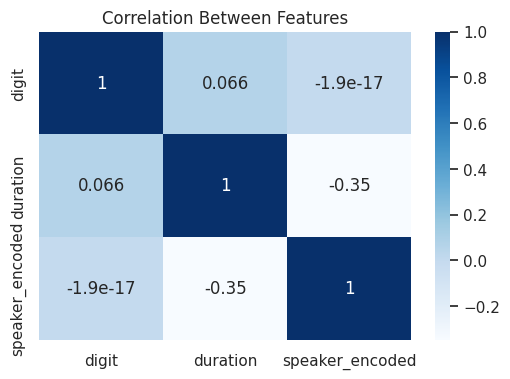

In [7]:
df['speaker_encoded'] = df['speaker'].astype('category').cat.codes

plt.figure(figsize=(6, 4))
sns.heatmap(df[['digit', 'duration', 'speaker_encoded']].corr(), annot=True, cmap='Blues')

plt.title("Correlation Between Features")
plt.show()


🎧 File: 6_theo_45.wav
📏 Duration: 0.43 sec
⚡ RMS Energy (mean): 0.0051
🎚️ Zero-Crossing Rate (mean): 0.1695
📈 Temporal Envelope (mean): 0.0057
🔁 Autocorr[0:5]: [0.53012484 0.5202287  0.49485725 0.46351656 0.43361217]


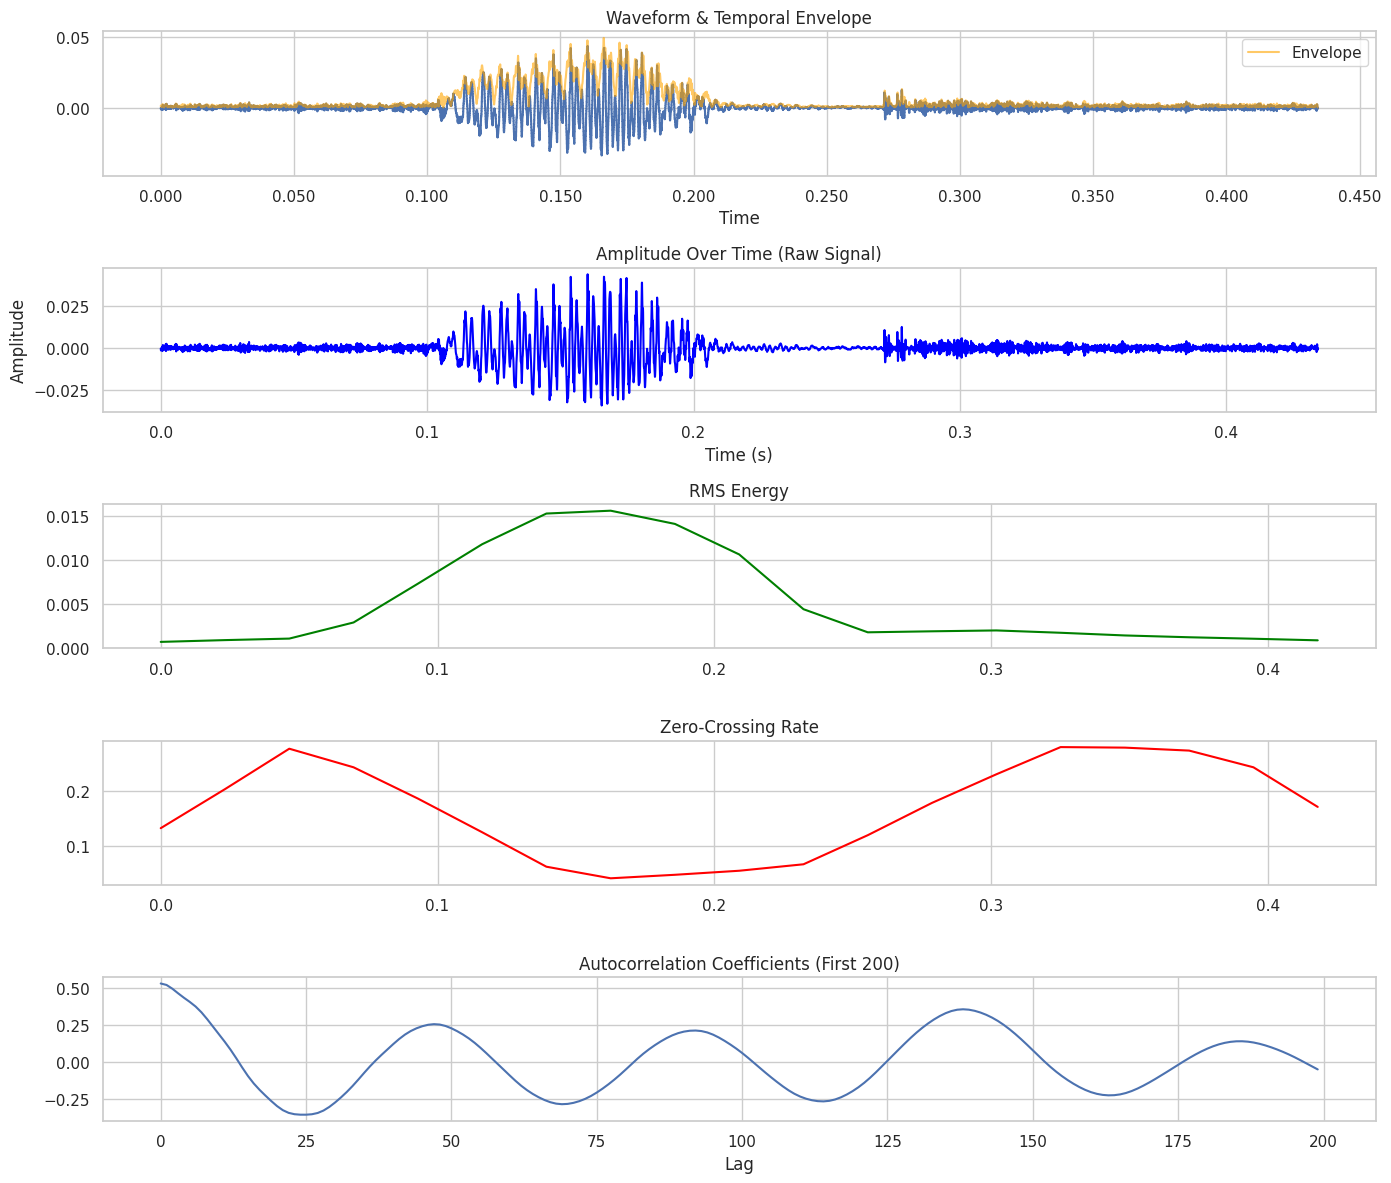

In [8]:
# Load sample
data_path = 'free-spoken-digit-dataset/recordings'
filename = np.random.choice(os.listdir(data_path))
filepath = os.path.join(data_path, filename)
y, sr = librosa.load(filepath)

# Duration
duration = librosa.get_duration(y=y, sr=sr)

# Time-domain features
rms = librosa.feature.rms(y=y)[0]
zcr = librosa.feature.zero_crossing_rate(y)[0]
times = librosa.times_like(rms, sr=sr)

# Temporal Envelope (Hilbert Transform method)
analytic_signal = hilbert(y)
amplitude_envelope = np.abs(analytic_signal)

# Autocorrelation coefficients (partial)
autocorr = np.correlate(y, y, mode='full')
autocorr = autocorr[autocorr.size // 2:]  # Take second half

# Print key values
print(f"🎧 File: {filename}")
print(f"📏 Duration: {duration:.2f} sec")
print(f"⚡ RMS Energy (mean): {np.mean(rms):.4f}")
print(f"🎚️ Zero-Crossing Rate (mean): {np.mean(zcr):.4f}")
print(f"📈 Temporal Envelope (mean): {np.mean(amplitude_envelope):.4f}")
print(f"🔁 Autocorr[0:5]: {autocorr[:5]}")

# Visualization
plt.figure(figsize=(14, 12))

# 1. Waveform + Envelope
plt.subplot(5, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.plot(np.linspace(0, duration, len(amplitude_envelope)), amplitude_envelope, color='orange', alpha=0.6, label='Envelope')
plt.title("Waveform & Temporal Envelope")
plt.legend()

# 2. Raw Amplitude
plt.subplot(5, 1, 2)
plt.plot(np.linspace(0, duration, len(y)), y, color='blue')
plt.title("Amplitude Over Time (Raw Signal)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# 3. RMS Energy
plt.subplot(5, 1, 3)
plt.plot(times, rms, color='green')
plt.title("RMS Energy")

# 4. Zero-Crossing Rate
plt.subplot(5, 1, 4)
plt.plot(times, zcr, color='red')
plt.title("Zero-Crossing Rate")

# 5. Autocorrelation
plt.subplot(5, 1, 5)
plt.plot(autocorr[:200])
plt.title("Autocorrelation Coefficients (First 200)")
plt.xlabel("Lag")

plt.tight_layout()
plt.show()


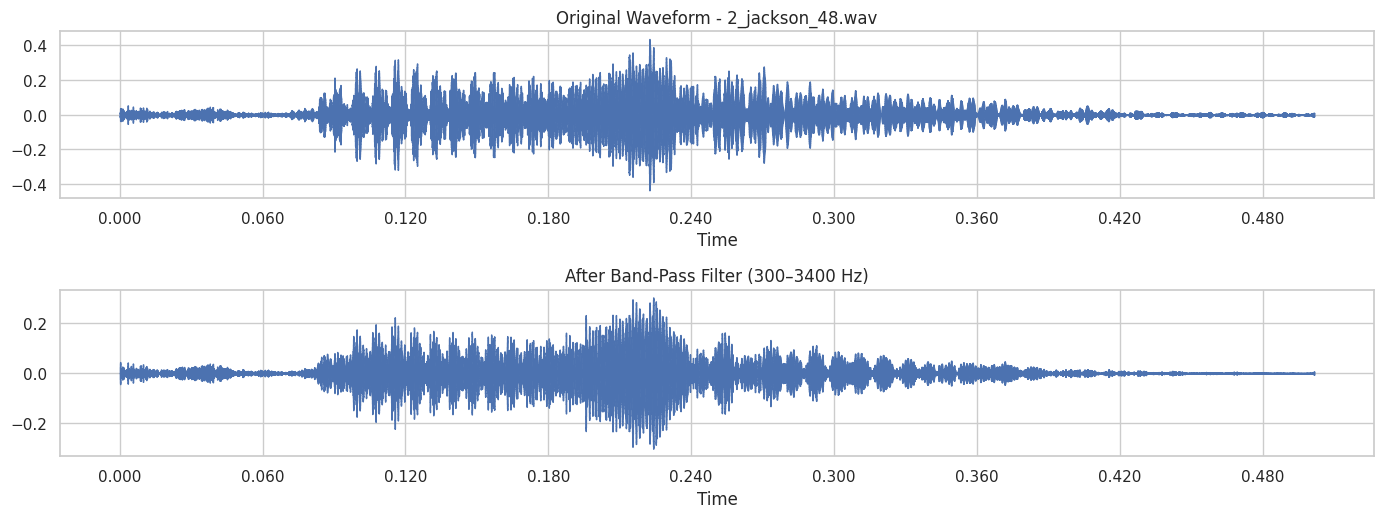

In [9]:
data_path = 'free-spoken-digit-dataset/recordings'
filename = np.random.choice([f for f in os.listdir(data_path) if f.endswith('.wav')])
filepath = os.path.join(data_path, filename)
y, sr = librosa.load(filepath)
# Band-pass filter (300–3400 Hz)
def bandpass_filter(signal, sr, lowcut=300, highcut=3400, order=4):
   nyq = 0.5 * sr
   low = lowcut / nyq
   high = highcut / nyq
   b, a = butter(order, [low, high], btype='band')
   return filtfilt(b, a, signal)
y_bandpass = bandpass_filter(y, sr)

# Plotting comparison
plt.figure(figsize=(14, 10))
# Original
plt.subplot(4, 1, 1)
librosa.display.waveshow(y, sr=sr)
plt.title(f"Original Waveform - {filename}")
# Bandpass
plt.subplot(4, 1, 2)
librosa.display.waveshow(y_bandpass, sr=sr)
plt.title("After Band-Pass Filter (300–3400 Hz)")

plt.tight_layout()
plt.show()

In [15]:
# Parameters 
win_length  = 1024                 # samples 128 ms at 8 kHz
hop_length  =  256                 # WHich is the number of samples we shift 
n_fft       = 2048                 # zero pad to dpuble the window length
window_fun  = "hann"               


In [11]:

#stft 
stft = librosa.stft(
    y,                            # my og signal
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    window=window_fun,
    center=True,                   # padding and we are doing refelction at the borderes
    pad_mode="reflect"
)
magnitude = np.abs(stft)
S_db = librosa.amplitude_to_db(magnitude, ref=np.max)
print(f"STFT shape: {stft.shape}  →  frames × fft‑bins")
# using librosa I couldn't understand the code so I will do it from scratch using numpy

STFT shape: (1025, 44)  →  frames × fft‑bins


In [16]:
def cahdSTFT(y, win_length, hop_length, n_fft, window=np.hanning(1024)):
   
    pad = win_length // 2
    y_padded = np.pad(y, pad_width=(pad, pad), mode='reflect')

    # Number of frames
    num_frames = 1 + (len(y_padded) - win_length) // hop_length

    # Pre-allocate STFT matrix
    stft_matrix = np.empty((n_fft // 2 + 1, num_frames), dtype=np.complex64)

    for i in range(num_frames):
        start = i * hop_length
        end = start + win_length
        frame = y_padded[start:end]

        if len(frame) < win_length:
            frame = np.pad(frame, (0, win_length - len(frame)))

        windowed = frame * window
        spectrum = np.fft.rfft(windowed, n=n_fft)  # rfft since signal is real
        stft_matrix[:, i] = spectrum

    return stft_matrix


stft = cahdSTFT(y)


magnitude = np.abs(stft)

# Convert to dB for more accurate observation
S_db = 20 * np.log10(magnitude / np.max(magnitude) )  


TypeError: cahdSTFT() missing 3 required positional arguments: 'win_length', 'hop_length', and 'n_fft'

In [ ]:
print(f"STFT shape: {stft.shape} → freq bins × frames")


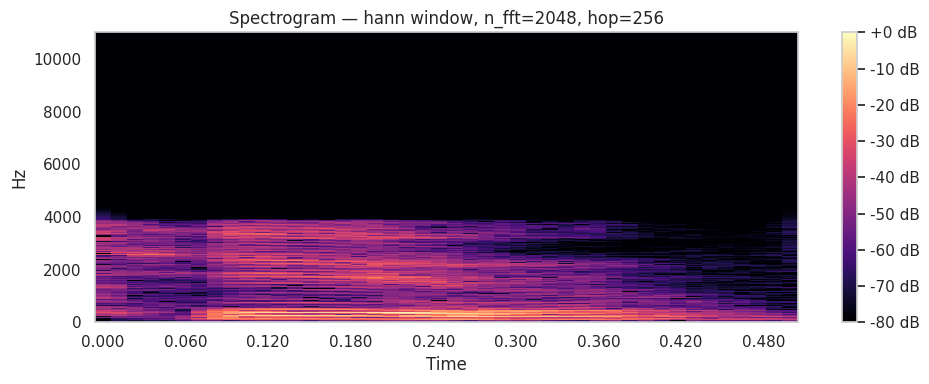

In [17]:
#spectogram visulising 
plt.figure(figsize=(10, 4))
librosa.display.specshow(
    S_db,
    sr=sr,
    hop_length=hop_length,
    x_axis="time",
    y_axis="hz"
)
plt.colorbar(format="%+2.0f dB")
plt.title(f"Spectrogram — {window_fun} window, n_fft={n_fft}, hop={hop_length}")
plt.tight_layout()
plt.show()

# this is using librosa

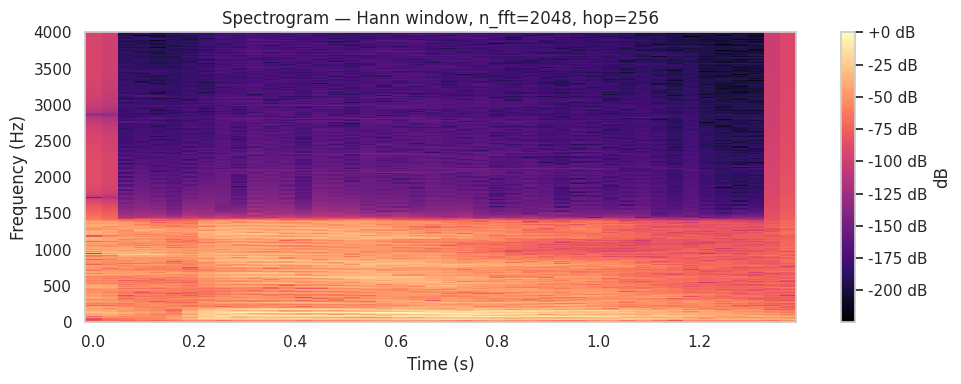

In [18]:
def CHADspectogram(S_db, sr, hop_length, n_fft, title="Spectrogram", cmap="magma"):
    time_axis = np.arange(S_db.shape[1]) * hop_length / sr
    freq_axis = np.linspace(0, sr / 2, S_db.shape[0])

    plt.figure(figsize=(10, 4))
    plt.pcolormesh(time_axis, freq_axis, S_db, shading="auto", cmap=cmap)
    plt.colorbar(format="%+2.0f dB", label="dB")
    plt.ylabel("Frequency (Hz)")
    plt.xlabel("Time (s)")
    plt.title(title)
    plt.tight_layout()
    plt.show()
magnitude = np.abs(stft)
S_db = 20 * np.log10(magnitude / np.max(magnitude) )

CHADspectogram(S_db, sr=8000, hop_length=256, n_fft=2048,
                 title="Spectrogram — Hann window, n_fft=2048, hop=256")

# this is using the from scratch STFT  

In [19]:
def compute_features(filepath):
    y, sr = librosa.load(filepath, sr=None)           # keep native 8 kHz

    # 1) Zero‑crossing rate
    zcr = librosa.feature.zero_crossing_rate(y)[0].mean()

    # 2) RMS  &  3) Signal energy
    rms    = librosa.feature.rms(y=y)[0].mean()
    energy = np.sum(y**2) / len(y)

    # 4) Acceleration coefficients (Δ² MFCC)
    mfcc  = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    n_frames = mfcc.shape[1]

    # Choose a safe odd width (≥3) not larger than n_frames
    if n_frames >= 9:
        width = 9
        delta2 = librosa.feature.delta(mfcc, order=2, width=width, mode='interp')
    elif n_frames >= 3:
        width = n_frames if n_frames % 2 else n_frames - 1
        delta2 = librosa.feature.delta(mfcc, order=2, width=width, mode='interp')
    else:
        # Too few frames for any width ≥3 → fall back to 'nearest' padding
        delta2 = librosa.feature.delta(mfcc, order=2, mode='nearest')

    delta2_mu = delta2.mean(axis=1)   # 13‑D

    # 5) Temporal envelope stats
    envelope = np.abs(hilbert(y))
    env_mean, env_std = envelope.mean(), envelope.std()

    # Assemble final 18‑D vector
    return np.hstack([
        zcr, rms, energy, env_mean, env_std, delta2_mu
    ]).astype(np.float32)


In [20]:
x = []   # Features
y = []   # Labels

DATASET_PATH = "free-spoken-digit-dataset/recordings"

for filename in files:
    filepath = os.path.join(DATASET_PATH, filename)

    features = compute_features(filepath)       
    label    = filename.split('_')[0]            # digit is the first token

    x.append(features)
    y.append(int(label))

x = np.array(x, dtype=np.float32)
y = np.array(y)

# alias so your next cell can still call 'X'
X = x


/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1932
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1965
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1805
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1541
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1960
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1761
  warnings.warn(
/home/haky/myenv/lib/python3


KNN Accuracy: 0.80


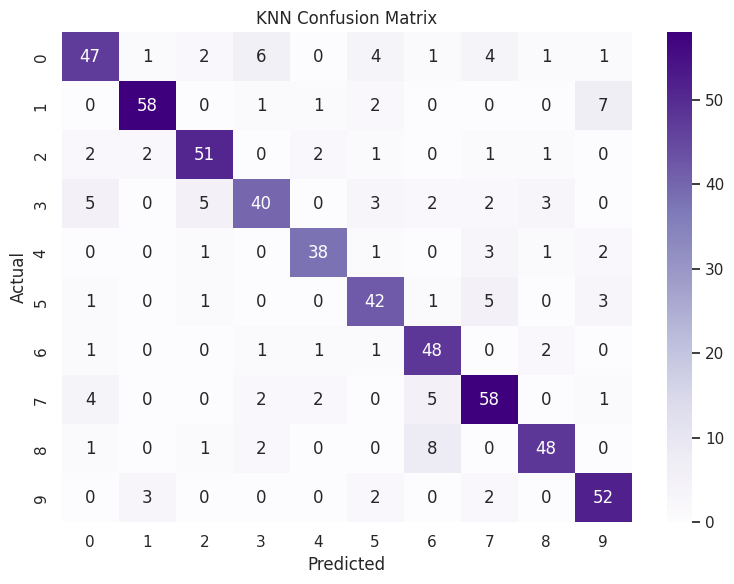

Accuracy: 0.69


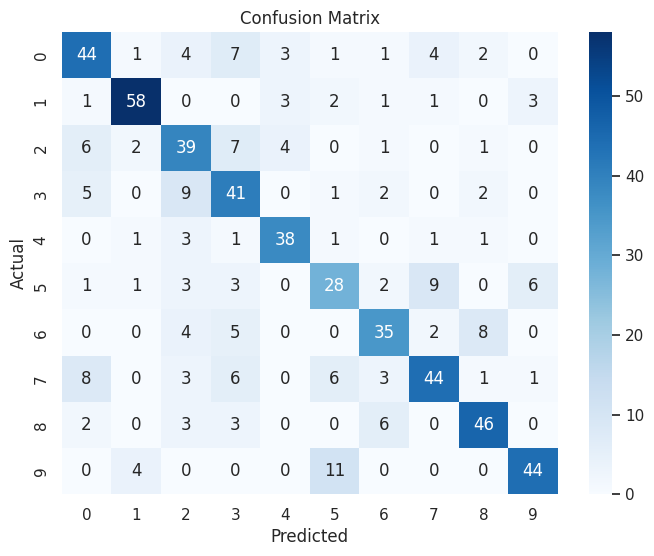

In [26]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Support vector machine (SVM) classifer:
SVM = SVC(kernel='linear', C=1.0)
#Try different kernel:
#SVM = SVC(kernel='rbf', C=1.0)
#SVM = SVC(kernel='poly' , degree=3, C=1.0) 
SVM.fit(x_train, y_train)
#K-nn Classfier:

KNN = KNeighborsClassifier(n_neighbors=5, weights='distance')  # try n_neighbors=3, 7 etc.
KNN.fit(x_train, y_train)

# Evaluate KNN
y_knn_pred = KNN.predict(x_test)
knn_acc = accuracy_score(y_test, y_knn_pred)
print(f"\nKNN Accuracy: {knn_acc:.2f}")

# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test, y_knn_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN Confusion Matrix")
plt.tight_layout()
plt.show()
# Evaluate the support vector machine (SVM) classfier:
y_pred = SVM.predict(x_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# Confusion Matrix:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1932
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1965
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1805
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1541
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1960
  warnings.warn(
/home/haky/myenv/lib/python3.13/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1761
  warnings.warn(
/home/haky/myenv/lib/python3

Epoch 01 | Val Acc: 0.363
Epoch 02 | Val Acc: 0.503
Epoch 03 | Val Acc: 0.577
Epoch 04 | Val Acc: 0.595
Epoch 05 | Val Acc: 0.640
Epoch 06 | Val Acc: 0.673
Epoch 07 | Val Acc: 0.710
Epoch 08 | Val Acc: 0.735
Epoch 09 | Val Acc: 0.738
Epoch 10 | Val Acc: 0.732
Epoch 11 | Val Acc: 0.757
Epoch 12 | Val Acc: 0.767
Epoch 13 | Val Acc: 0.767
Epoch 14 | Val Acc: 0.767
Epoch 15 | Val Acc: 0.757
Epoch 16 | Val Acc: 0.773
Epoch 17 | Val Acc: 0.763
Epoch 18 | Val Acc: 0.780
Epoch 19 | Val Acc: 0.798
Epoch 20 | Val Acc: 0.803
Epoch 21 | Val Acc: 0.792
Epoch 22 | Val Acc: 0.792
Epoch 23 | Val Acc: 0.783
Epoch 24 | Val Acc: 0.787
Epoch 25 | Val Acc: 0.798
Epoch 26 | Val Acc: 0.805
Epoch 27 | Val Acc: 0.803
Epoch 28 | Val Acc: 0.785
Epoch 29 | Val Acc: 0.792
Epoch 30 | Val Acc: 0.803


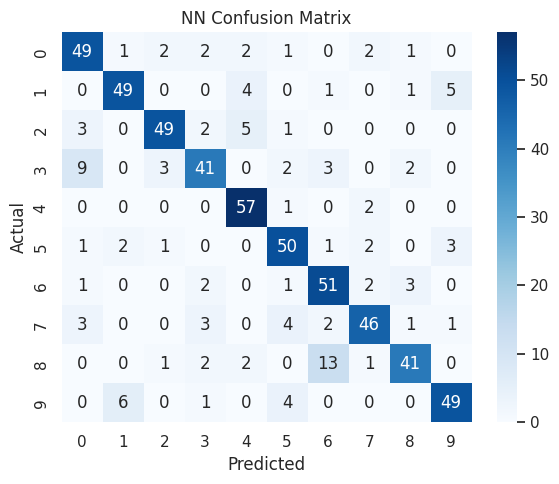

Final Accuracy: 0.803


In [22]:
x, y = [], []
x, y = [], []

for row in df.itertuples(index=False):
    # Use the correct path column
    if hasattr(row, 'filepath'):
        path = row.filepath
    elif hasattr(row, 'filename'):
        path = os.path.join('free-spoken-digit-dataset/recordings', row.filename)
    else:
        raise ValueError("Your dataframe must contain 'filepath' or 'filename' column.")

    features = compute_features(path)
    x.append(features)
    y.append(row.digit)

# 2. Train/Val Split
x_train, x_val, y_train, y_val = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Convert to torch tensors
X_train = torch.tensor(x_train)
y_train = torch.tensor(y_train)
X_val   = torch.tensor(x_val)
y_val   = torch.tensor(y_val)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train = X_train.to(device), y_train.to(device)
X_val,   y_val   = X_val.to(device),   y_val.to(device)

# 4. Define NN
model = torch.nn.Sequential(
    torch.nn.Linear(18, 64), torch.nn.ReLU(),
    torch.nn.Linear(64, 64), torch.nn.ReLU(),
    torch.nn.Linear(64, 10)
).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 5. Training loop
EPOCHS = 30
BATCH_SIZE = 64

for epoch in range(1, EPOCHS+1):
    model.train()
    idx = torch.randperm(X_train.size(0))
    Xb, yb = X_train[idx], y_train[idx]

    for i in range(0, len(yb), BATCH_SIZE):
        xb_batch = Xb[i:i+BATCH_SIZE]
        yb_batch = yb[i:i+BATCH_SIZE]

        optimizer.zero_grad()
        preds = model(xb_batch)
        loss = loss_fn(preds, yb_batch)
        loss.backward()
        optimizer.step()

    # Evaluate
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val).argmax(dim=1)
        acc = (val_preds == y_val).float().mean().item()
    print(f"Epoch {epoch:02d} | Val Acc: {acc:.3f}")

# 6. Confusion Matrix
preds = val_preds.cpu().numpy()
y_val_np = y_val.cpu().numpy()

cm = confusion_matrix(y_val_np, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.title("NN Confusion Matrix")
plt.tight_layout(); plt.show()

print(f"Final Accuracy: {accuracy_score(y_val_np, preds):.3f}")